# 1. Methods, iterables, and generators for reading files

We all need to open, close, and save data to files using Python. Loading a file always involves reading the lines in the file, and possibly doing some processing on each line. An example file $\textbf{test_data.txt}$ contains 1,000,000 rows (lines) and 3 columns separated by an empty space.

In [1]:
import time 

In [11]:
fn = "generators/test_data.txt"

##### The Python Method

In [12]:
def method_loader(fn):
    with open(fn) as fid:
        lines = fid.readlines() # Read in lines until reaching EOF
        lines = [line.strip("\n").split(" ")[-1] for line in lines] # Process each line
    return lines

In [13]:
for processed_line in method_loader(fn):
    break

The entire file was read into memory with the .readlines() call, before any line processing was performed.

Reading files like this shouldn't be a problem for file sizes up to ~1G. But sometimes we have no choice and have to work with large files (sometimes hundreds of gigs). As a result the readlines operation can take a very long time. Furthermore, if the file is too large to load into memory, python will throw the __MemoryError__ exception and your program will terminate *with error*.

We frequently encounter large datafiles at NCAR. What can we do about it? 

Reading and processing one line at a time would solve this problem. We could even process an "infinitely" large file, which means any file that's too large to load fully into memory.

This kind of file reading is called __lazy__ reading.

##### The Python Generator

There is a special tool in the python toolbox that easily enables lazy reading called a generator. The generator object is built on top of python's Iterator object class, but I will cover them in reverse below.

In [14]:
def generator_loader(fn):
    with open(fn, "r") as fid:
        for line in fid:
            yield line.strip("\n").split(" ")[-1]

We've replaced the return with something new named $\color{green}{\textbf{yield}}$. This chunk of code looks similar to the method_loader!

Test it.

In [53]:
for processed_line in generator_loader(fn):
    print(processed_line)
    break # Stop early, I don't need to print 1,000,000 lines!

0


It behaves similarly when in use as compared to the method variant presented above. The big difference is that the generator version is more memory efficient because, through $\color{green}{\textbf{yield}}$, lines are read into memory one at a time, returned, released, ..., until reaching the end of the file (EOF). 

That is to say $\color{green}{\textbf{yield}}$ returns more than once, whereas $\color{green}{\textbf{return}}$ in a method signals the end (in terms of memory usage, as it is freed and the method is exited). 

Generators work nicely with serialized data ... you may have __*dumped*__ data using the pickle library before. The pickle library allows you to do that for the entire file, all in one go, or line-by-line as the example below illustrates:

In [16]:
import pickle

In [18]:
fn_pkl = "generators/test_data.pkl"

In [19]:
def write_to_pickle(data, fn):
    with open(fn, "wb") as fid:
        for line in data:
            pickle.dump(line, fid) # Iteration over .dump

In [21]:
write_to_pickle(
    method_loader(fn),
    fn_pkl
)

From here will assume that we do not know how many lines are in our serialized data dump:

In [22]:
def load_from_pickle(fn):
    with open(fn, "rb") as fid:
        while True: # Keep looping with while.
            yield pickle.load(fid) # Iteration over .load

where the $\color{green}{\textbf{while True}}$ clause will keep looping over the call to load pickled data until we reach the end of the file. 

Test it!

In [23]:
for row in load_from_pickle(fn_pkl):
    continue

EOFError: Ran out of input

It failed! 

There must still be a signal that can be used to stop the geneartor from yielding the next line when it does not exist. 

Note that the *exception* python threw was an $\color{red}{\textbf{EOFError}}$ exception. We can catch that and use it to exit the generator:

In [24]:
def load_from_pickle(fn):
    with open(fn, "rb") as fid:
        try:
            while True: # We do not necessarily know how many lines are in fn
                yield pickle.load(fid)               
        except EOFError:
            pass # Do nothing and leave read_from_pickle without error 

Now it will run without error:

In [25]:
for row in load_from_pickle(fn_pkl):
    continue
    
# Finishes without error

This is rather clunky! Now we have to do *exception handling* (gasp). You might be wondering what good are python generators at helping us to simplify memory usage when this style of coding makes the workflow more complex. We could have relied on python's Iterator objects (covered next), to do lazy reading.

Fortunatly, python developers also included a generalized version of yield, $\color{green}{\textbf{yield from}}$ for these siuations.

In [26]:
def load_from_pickle(fn):
    with open(fn, "rb") as fid:
        yield from pickle.load(fid)

In [27]:
for row in load_from_pickle(fn_pkl):
    continue

In [28]:
# Finishes without error. 

In short, generators allow us to write simple code that helps to simplfy memory usage when working with large data files.

##### The Python Iterable

Before generators were introduced, one relied on a python __Iterator__ object to produce lazy readers. Iterable classes are not too difficult to write, but they have dependencies, in particular, they must contain the $\color{blue}{\textbf{__iter__}}$ and $\color{blue}{\textbf{__next__}}$ "thunder" methods. 

A simple example with our serialized (pickled) data from above:

In [44]:
class read_from_pickle_iterable:
    
    def __init__(self, fn):
        self.fn = fn
        self.fid = open(self.fn, "rb")
        
    def __iter__(self):
        return self
    
    def __next__(self):
        try:
            return pickle.load(self.fid)
        except EOFError:
            raise StopIteration

The thunder method $\color{blue}{\textbf{__iter__}}$ returns the object itself (through self!), while $\color{blue}{\textbf{__next__}}$ is used to return the result of the .load call on the opened file.

In [49]:
rfpi = read_from_pickle_iterable(fn_pkl)

Using the Iterator's $\color{blue}{\textbf{__next__}}$ functionality, we then grab the lines from the file one-by-one without opening the entire file:

In [51]:
while True:
    next(rfpi) # Use next like this

StopIteration: 

which dies as intended when the $\color{red}{\textbf{EOFError}}$ caught and the $\color{red}{\textbf{StopException}}$ exception was thrown using the $\color{green}{\textbf{raise}}$ clause. When the iterator object is rolled out in a loop (or by list(), etc) it will exit without error:

In [52]:
for line in read_from_pickle_iterable(fn_pkl):
    continue

### Why even have generators when there are already iterators?

The answer is because generators are more compact and easier to write, as you do not have to explicitly sub-class them with the $\color{blue}{\textbf{__iter__}}$ and $\color{blue}{\textbf{__next__}}$. That's taken care of under-the-hood with the generator class. But the converse is not true: iterables do not have the yield capability.

### When should I use a generator rather than a method?

There are lots of scenerios, in addition to data loading! Note that in the first method example above, a list was returned. Do you need all elements of the list, all at the same time? If the answer is no, then you want to try to use a generator if that file is large in size!

With generators one tries to balance the time spent performing operations with/on the data with memory utilization. Using them will often be determined by how your program is designed to run and utilize resources. If you are presented with a significant memory bottleneck, generators are very often the way to go. However if your program does not have said memory issue, using a generator might result in the program running significantly slower. 

As you use generators more and more in your work-flow, you will learn to apply them when they are needed and when to avoid them when they do not offer any benefit over using methods.

# 2. Data Loaders for ML Pipelines

Next, let us combine methods, generators and iterators and build something a little more involved -- how about effecient data objects for preparation and data ingestion into ML models?

We will look at the holodec data (as of Oct 12, 2020), which contains large hologram images and numerical data accompaning each image. The holodec data is saved as netCDF format -- by default the data type only supports lazy reading!

In [6]:
from holodecml.data import *

The main method to load the data is reproduced here (which calls other methods, not shown) 

In [25]:
def load_raw_datasets(path_data, num_particles, split, output_cols, subset):
    ds = open_dataset(path_data, num_particles, split)
    if subset:
        ix = int(subset * ds['image'].shape[0])
        inputs = ds['image'][:ix].values
        outputs = ds[output_cols].to_dataframe()
        outputs = outputs[outputs["hid"] < (ix+1)]
    else:
        inputs = ds["image"].values
        outputs = ds[output_cols].to_dataframe()    
    ds.close()
    return inputs, outputs

For most data files, there is nothing wrong with this method -- its compact, easy to read, and does what you want it to do. As we have seen with the file loading example above, methods quickly become memory inefficient once files become large in size.

In [26]:
path_data = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/"
num_particles = "multi"
split = 'train'
subset = False
output_cols = ["x", "y", "z", "d", "hid"]

In [5]:
t0 = time.time()
inputs, outputs = load_raw_datasets(path_data, num_particles, split, output_cols, subset)
t1 = time.time()
print(t1-t0)

This file is pretty large, not large enough to cause a memory overflow, but it still takes about 5 minuites to load. 

Let us first write a lazy reader that returns the same thing data as the above method, but one row at a time. Then we will utilize special iterable objects from the Torch, Tensorflow, and Keras libraries that will enable multiprocessing with multiple simultanous workers for creating batches as well as other transformations.

### The Dataset Reader

In [27]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from torch.utils.data import Dataset, DataLoader

Torch.utils.data.Dataset and tensorflow.keras.utils.Sequence objects both require a custom "Reader" class to contain the $\color{blue}{\textbf{__len__}}$ and $\color{blue}{\textbf{__getitem__}}$ thunder methods:

In [50]:
class HologramReader(Dataset): # Sequence
    
    'Generates data for Keras/Tensorflow/Torch environments'
    
    def __init__(self, 
                 path_data, 
                 num_particles, 
                 split, 
                 output_cols, 
                 subset, 
                 maxnum_particles = 100):
        
        'Initialization'
        self.ds = open_dataset(path_data, num_particles, split)
        self.output_cols = [x for x in output_cols if x != 'hid']        
        self.hologram_numbers = list(range(len(self.ds.hologram_number.values)))
        self.maxnum_particles = maxnum_particles
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.hologram_numbers)
    
    def __getitem__(self, idx):
        'Return one row of data'
        
        # Select one "row" from the dataset
        hologram = self.hologram_numbers[idx]

        x_out = self.ds["image"][hologram].values
        y_out = np.zeros((
            self.maxnum_particles if self.maxnum_particles else self.num_particles, 
            len(self.output_cols)
        ))
        particles = np.where(self.ds["hid"] == hologram + 1)[0]
        for l, p in enumerate(particles):
            for m, col in enumerate(self.output_cols):
                y_out[l, m] = self.ds[col].values[p]

        return x_out, y_out

In [51]:
data_reader = HologramReader(path_data, num_particles, split, output_cols, subset)

The method $\color{blue}{\textbf{__getitem__}}$ is used to select whichever hologram we want (take the one labeled 0):

In [30]:
x, y = data_reader.__getitem__(0)

In [31]:
print(x.shape, y.shape)

(600, 400) (100, 4)


Make a quick plot:

In [32]:
import matplotlib.pyplot as plt

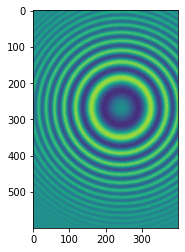

In [33]:
plt.imshow(x)

### The Iterator

##### Torch

To make the the torch/keras Reader class iterable, we can wrap a torch DataLoader object around it which will enable batching, multiprocessing capabilities, and other options. As noted, the DataLoader object requires that the Reader class contains the $\color{blue}{\textbf{__len__}}$ and $\color{blue}{\textbf{__getitem__}}$ thunder methods:

In [34]:
data_iterator = DataLoader(
    data_reader,
    num_workers = 8,
    batch_size = 32,
    shuffle = True
)

In [35]:
for (x, y) in data_iterator:
    print(x.shape, y.shape)
    break

torch.Size([32, 600, 400]) torch.Size([32, 100, 4])


The DataLoader object will take care of creating independent workers that each will load the Reader and put the row data onto a queue where the data is sent back to a Manager that feeds the model. The first few calls to data_iterator will be slow as the workers have to be initialized before they can start putting data onto a queue.

In a future blog post we will write our own multiprocessing worker class, but lets appreciate how easy the big three libraries have made it for us to get to this point.

##### Keras

When training a model with Keras, all we have to do is swap $\color{black}{\textbf{HologramReader(Dataset)}}$ for $\color{black}{\textbf{HologramReader(Sequence)}}$ and make no other changes. We also could have skipped using the inheritance approach and specify the output type (torch tensor versus numpy tensor) upon return.

In older Keras versions, the Reader would be fed into the Model.fit_generator method, which allowed one to toggle the number of workers and queue size. The important bit about the Sequence object is that it is thread-safe, meaning the workers spawned will not duplicate data chunks (this isn't necessarily always a problem but depends on the type of data being used).

The torch DataLoader came with shuffle capability (by initializing a random order using the $\color{blue}{\textbf{__len__}}$ method), whereas in the Sequence object, shuffle functionality (and whatever else you want) can be enabled by adding a method typically called $\color{blue}{\textbf{on_epoch_end}}$ that will shuffle after some number of data points have been returned. 

##### Tensorflow

But, since the Sequence object was recently deprecated in favor of Tensorflow's data objects, we will proceed by setting up one of those. We only have to make a few adjustments to the above Readers:

In [36]:
class TFHologramReader: 
    
    'Generates data for Keras/Tensorflow/Torch environments'
    
    def __init__(self, 
                 path_data, 
                 num_particles, 
                 split, 
                 output_cols, 
                 subset, 
                 maxnum_particles = 100):
        
        'Initialization'
        self.ds = open_dataset(path_data, num_particles, split)
        self.output_cols = [x for x in output_cols if x != 'hid']        
        self.hologram_numbers = list(range(len(self.ds.hologram_number.values)))
        self.maxnum_particles = maxnum_particles
    
    def __call__(self):
        'Return one row of data'
        for k, hologram in enumerate(self.hologram_numbers):
            # Select one "row" from the dataset
            x_out = self.ds["image"][hologram].values
            y_out = np.zeros((
                self.maxnum_particles if self.maxnum_particles else self.num_particles, 
                len(self.output_cols)
            ))
            particles = np.where(self.ds["hid"] == hologram + 1)[0]
            for l, p in enumerate(particles):
                for m, col in enumerate(self.output_cols):
                    y_out[l, m] = self.ds[col].values[p]

            yield tf.convert_to_tensor(x_out), tf.convert_to_tensor(y_out)

Note that this Reader's $\color{blue}{\textbf{__call__}}$ is a generator, whereas before we used a method.

Calling and using the reader is the same as before. First, initialize an instance by setting the input variables:

In [37]:
tf_data_generator = TFHologramReader(
    path_data, num_particles, split, output_cols, subset
)

Then we wrap Tensorflow's Dataset object around the generator, using the $\color{blue}{\textbf{from_generator}}$ method within the Dataset object, and setting the tensor types explictly:

In [38]:
tf_data_iterator = tf.data.Dataset.from_generator(
    tf_data_generator, 
    (tf.dtypes.float32, tf.dtypes.float32)
)

Setting the batch size can be done by

In [39]:
tf_data_iterator = tf_data_iterator.batch(32)

Shuffling is a little more complex. Since a generator is in play, a memory buffer of size buffer_size will be created and rows put into it. Then, batches are selected from it and returned. Note that there will be a delay in the begining as the buffer has to fill up:

In [42]:
tf_data_iterator = tf_data_iterator.shuffle(buffer_size=100)

To get true random sampling, the buffer size would need to be the size of the data set.

In practice, one should shuffle the hologram numbers list in the TFReader upon initialization since they are available, similar to what needed to be done when using the keras Sequence object. For the sake of illustration we use tensorflows method for shuffling.

In [43]:
for (x, y) in tf_data_iterator:
    print(x.shape, y.shape)
    break

(32, 600, 400) (32, 100, 4)


The number of workers can be set when training the model through the .fit() super-class (which contains an machinery for rolling out the Reader and feeding the batches it into the model):

Note that we could use any of these approaches with either ML language, though the torch and tensorflow versions are superior to the now-deparecated Sequence. Enabling multiprocessing with Tensorflow Data objects is rather tricky though, we just let the Keras methods handle that here. We will cover that another time!

Note that these special iterator objects contain many other features not covered here, so be sure to check out the documentation!

Tensorflow Dataset: [https://www.tensorflow.org/api_docs/python/tf/data/Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

Torch Dataset: [https://pytorch.org/docs/stable/data.html](https://pytorch.org/docs/stable/data.html)

Feel free to email me (John Schreck, schreck@ucar.edu) with any questions / mistakes / whatever!